In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [3]:
import pickle

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [5]:
pd.__version__

'1.4.2'

In [6]:
def preprocess_data(file_path):
    df = pd.read_parquet(file_path)
    
    df.lpep_pickup_datetime= pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    
    df["duration"]= df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60 )
    
    df = df[(df.duration>1) & (df.duration<61)]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df 

In [59]:
train_data = preprocess_data("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
val_data = preprocess_data("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")

In [16]:
val_data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-02-01 00:15:53,2024-02-01 00:24:20,N,1.0,75,161,1.0,2.77,13.50,...,0.5,3.75,0.0,NaN,1.0,22.50,1.0,1.0,2.75,8.450000
1,2,2024-01-31 22:59:22,2024-01-31 23:27:14,N,1.0,43,242,1.0,7.76,36.60,...,0.5,0.00,0.0,NaN,1.0,39.10,2.0,1.0,0.00,27.866667
2,2,2024-02-01 00:30:29,2024-02-01 00:35:32,N,1.0,75,238,1.0,1.03,7.90,...,0.5,2.60,0.0,NaN,1.0,13.00,1.0,1.0,0.00,5.050000
3,2,2024-01-31 23:56:42,2024-02-01 00:06:53,N,1.0,80,17,2.0,1.36,11.40,...,0.5,4.17,0.0,NaN,1.0,18.07,1.0,1.0,0.00,10.183333
5,2,2024-02-01 00:06:23,2024-02-01 00:10:10,N,1.0,97,25,1.0,0.34,5.10,...,0.5,0.00,0.0,NaN,1.0,7.60,2.0,1.0,0.00,3.783333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53572,2,2024-02-29 21:07:00,2024-02-29 21:34:00,None,NaN,223,137,NaN,5.43,32.16,...,0.0,7.18,0.0,NaN,1.0,43.09,NaN,NaN,NaN,27.000000
53573,2,2024-02-29 22:35:38,2024-02-29 22:46:25,None,NaN,256,37,NaN,1.50,2.70,...,0.0,2.74,0.0,NaN,1.0,6.44,NaN,NaN,NaN,10.783333
53574,2,2024-02-29 22:14:00,2024-02-29 22:39:00,None,NaN,75,33,NaN,10.07,47.14,...,0.0,15.27,0.0,NaN,1.0,66.16,NaN,NaN,NaN,25.000000
53575,2,2024-02-29 22:41:00,2024-02-29 22:53:00,None,NaN,97,33,NaN,1.54,12.22,...,0.0,3.30,0.0,NaN,1.0,16.52,NaN,NaN,NaN,12.000000


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

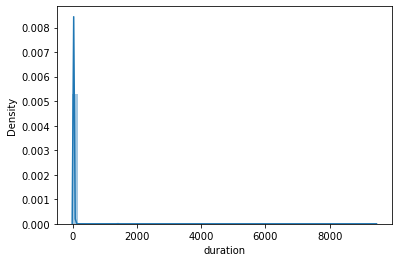

In [10]:
sns.distplot(df.duration)

In [11]:
df.duration.describe()

count    2.964624e+06
mean     1.561295e+01
std      3.485105e+01
min     -1.356667e+01
25%      7.150000e+00
50%      1.163333e+01
75%      1.868333e+01
max      9.455400e+03
Name: duration, dtype: float64

In [12]:
df["duration"].describe(percentiles= [.90, .98, .99])

count    2.964624e+06
mean     1.561295e+01
std      3.485105e+01
min     -1.356667e+01
50%      1.163333e+01
90%      2.886667e+01
98%      5.100000e+01
99%      6.045000e+01
max      9.455400e+03
Name: duration, dtype: float64

In [17]:
numerical = ['trip_distance']

In [36]:
train_data['PULocationID'].dtypes

dtype('O')

In [37]:
train_data['PU_DO']= train_data['PULocationID'] + '_' + train_data['DOLocationID']
val_data['PU_DO']= val_data['PULocationID']+ '_'+ val_data['DOLocationID']

In [38]:
categorical = ["PU_DO"] #['PULocationID', 'DOLocationID']  PU_DO works better as feature
#df[categorical] = df[categorical].astype(str)

In [39]:
train_dict= train_data[categorical + numerical].to_dict(orient ='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

target = 'duration'
Y_train = train_data[target].values

val_dict= val_data[categorical + numerical].to_dict(orient ='records')
X_val = dv.transform(val_dict)

Y_val = val_data[target].values


In [26]:
dv.feature_names_

['DOLocationID', 'PULocationID', 'trip_distance']

In [23]:
X_train.shape , X_val.shape

((73876, 3), (51489, 3))

In [40]:
Linear_re = LinearRegression()
Linear_re.fit(X_train, Y_train)

LinearRegression()

In [41]:
pred = Linear_re.predict(X_val)
mean_squared_error(Y_val, pred, squared=False)

6.173866891570694

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


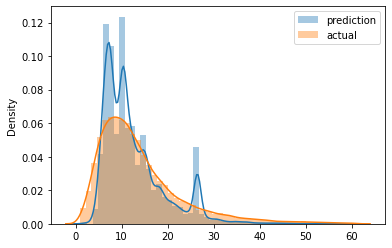

In [42]:
sns.distplot(pred, label ='prediction')
sns.distplot(Y_val, label ='actual')
plt.legend()

In [61]:
with open("../models/lin_reg.bin" ,'wb') as f_out:
    pickle.dump((dv,Linear_re), f_out)  # vectorization, lin_reg model

In [46]:
import os

os.getcwd()


'/workspaces/MLOps/01-intro'

# homework tasks

In [5]:
def yellow_cab_data(file_path):
    df = pd.read_parquet(file_path)
    
    df.tpep_pickup_datetime= pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    
    df["duration"]= df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60 )
    
    #df = df[(df.duration>1) & (df.duration<61)]

    return df 

Q1. Downloading the data  ===> 20 columns

In [6]:
tr_dt_y = yellow_cab_data("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")
val_dt_y = yellow_cab_data("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")

In [12]:
tr_dt_y

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN,13.983333
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN,19.450000
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN,24.516667
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN,13.000000


Q2. Computing duration ====> 42.59

In [8]:
tr_dt_y.duration.describe() # before dropping outliers

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

Q3. Dropping outliers ===> 98%

In [13]:
tr_dt_y = tr_dt_y[(tr_dt_y.duration>1)& (tr_dt_y.duration<=60)]

In [15]:
tr_dt_y.duration.describe()

count    3.043258e+06
mean     1.408623e+01
std      1.005147e+01
min      1.666667e-02
25%      7.100000e+00
50%      1.145000e+01
75%      1.810000e+01
max      6.098333e+01
Name: duration, dtype: float64

Q4. One-hot encoding ===> dimensionality of this matrix (number of columns) 515

In [7]:
categorical=['PULocationID','DOLocationID']

In [14]:
train_data = tr_dt_y[categorical].astype(str).to_dict(orient='records')

In [23]:
train_data

[{'PULocationID': '161', 'DOLocationID': '141'},
 {'PULocationID': '43', 'DOLocationID': '237'},
 {'PULocationID': '48', 'DOLocationID': '238'},
 {'PULocationID': '138', 'DOLocationID': '7'},
 {'PULocationID': '107', 'DOLocationID': '79'},
 {'PULocationID': '161', 'DOLocationID': '137'},
 {'PULocationID': '239', 'DOLocationID': '143'},
 {'PULocationID': '142', 'DOLocationID': '200'},
 {'PULocationID': '164', 'DOLocationID': '236'},
 {'PULocationID': '141', 'DOLocationID': '107'},
 {'PULocationID': '234', 'DOLocationID': '68'},
 {'PULocationID': '79', 'DOLocationID': '264'},
 {'PULocationID': '164', 'DOLocationID': '143'},
 {'PULocationID': '138', 'DOLocationID': '33'},
 {'PULocationID': '33', 'DOLocationID': '61'},
 {'PULocationID': '79', 'DOLocationID': '186'},
 {'PULocationID': '90', 'DOLocationID': '48'},
 {'PULocationID': '113', 'DOLocationID': '255'},
 {'PULocationID': '237', 'DOLocationID': '239'},
 {'PULocationID': '143', 'DOLocationID': '229'},
 {'PULocationID': '137', 'DOLocat

In [15]:
dv = DictVectorizer()
train_X = dv.fit_transform(train_data) 

In [16]:
train_X

<3008892x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6017784 stored elements in Compressed Sparse Row format>

Q5. Training a model  loss ====> 7.64

In [17]:
target ="duration"
train_Y =  tr_dt_y[target].values

In [18]:
train_Y

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [19]:
linear_reg= LinearRegression()
linear_reg.fit(train_X,train_Y)

LinearRegression()

In [20]:
pred = linear_reg.predict(train_X)
loss = root_mean_squared_error(train_Y, pred)
loss

7.648230348107909

Q6. Evaluating the model  loss ===> 7.81

In [27]:
val_dt_y = val_dt_y[(val_dt_y.duration>1)& (val_dt_y.duration<=60)]

In [28]:
val_data = val_dt_y[categorical].astype(str).to_dict(orient='records')
val_X = dv.transform(val_data)
val_Y = val_dt_y[target].values

In [29]:
val_X 

<2855630x515 sparse matrix of type '<class 'numpy.float64'>'
	with 5711252 stored elements in Compressed Sparse Row format>

In [30]:
preds = linear_reg.predict(val_X)
losses = root_mean_squared_error(val_Y, preds)
losses

7.810109142043377